In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**AI Compliance Audit Agent — Kaggle Capstone Project**
A Smart, Autonomous Agent that Detects Safety Violations, Assigns Risk Scores, and Generates Instant Compliance Reports.

**Overview**

The AI Compliance Audit Agent is an autonomous safety-checking system built using Cohere’s Chat API, Python, and a custom Gradio interface.
It analyzes any text for privacy violations, policy issues, and sensitive information — then produces:

✔ A clear risk score
✔ A list of detected violations
✔ A safe rewritten version of the content
✔ A full human-readable compliance report

This solves a major real-world challenge:
manually reviewing data for privacy and safety is slow — this agent automates it instantly.

**What This Agent Does**
**This AI agent:**

Detects risky or non-compliant content (ex: leaks of personal data)

Scores the text on a 0–100 risk scale

Generates a corrected version that is safe to publish

Provides recommendations to fix issues

Outputs a structured, professional audit report

All within seconds.

**Why It Is Useful**

**Organizations deal with huge volumes of text:**

Emails

Documents

Policies

Reports

User submissions

Chat interactions

**Manual review is slow and error-prone.
This agent:**

✔ automates compliance
✔ reduces human effort
✔ prevents data leaks
✔ ensures privacy & safety
✔ saves time for teams & companies

This is a highly practical real-world AI application, making it a strong candidate for the Capstone challenge.

**Architecture**

The agent is powered by the following modules:

**1️.Rule Checker Module**

Detects policy violations like:

personal data

security issues

unapproved content

confidential information

**2️.Risk Scoring Engine**

Converts violations into a numerical risk score (0–100)

**3️.AI Brain (Cohere Chat API)**

Generates:

safe rewrite

risk explanation

remediation suggestions

**4️.Human-Readable Formatter**

Converts JSON response into polished natural-language output

**5.Gradio Frontend**

Clean, beautiful UI

Interactive text input

Real-time report generation

**Example Input**
This document reveals private user data including phone numbers and was not approved by security.

**Example Output (Shortened)**
Detected issues:
- private data
- unapproved content

Risk Score: 40 / 100 (Medium Risk)

Safe Rewrite:
"This document contains confidential information and requires approval before release."

**Recommendations:**
1. Remove all user data.
2. Implement redaction processes.
3. Ensure review workflow.

Gradio UI Screenshot
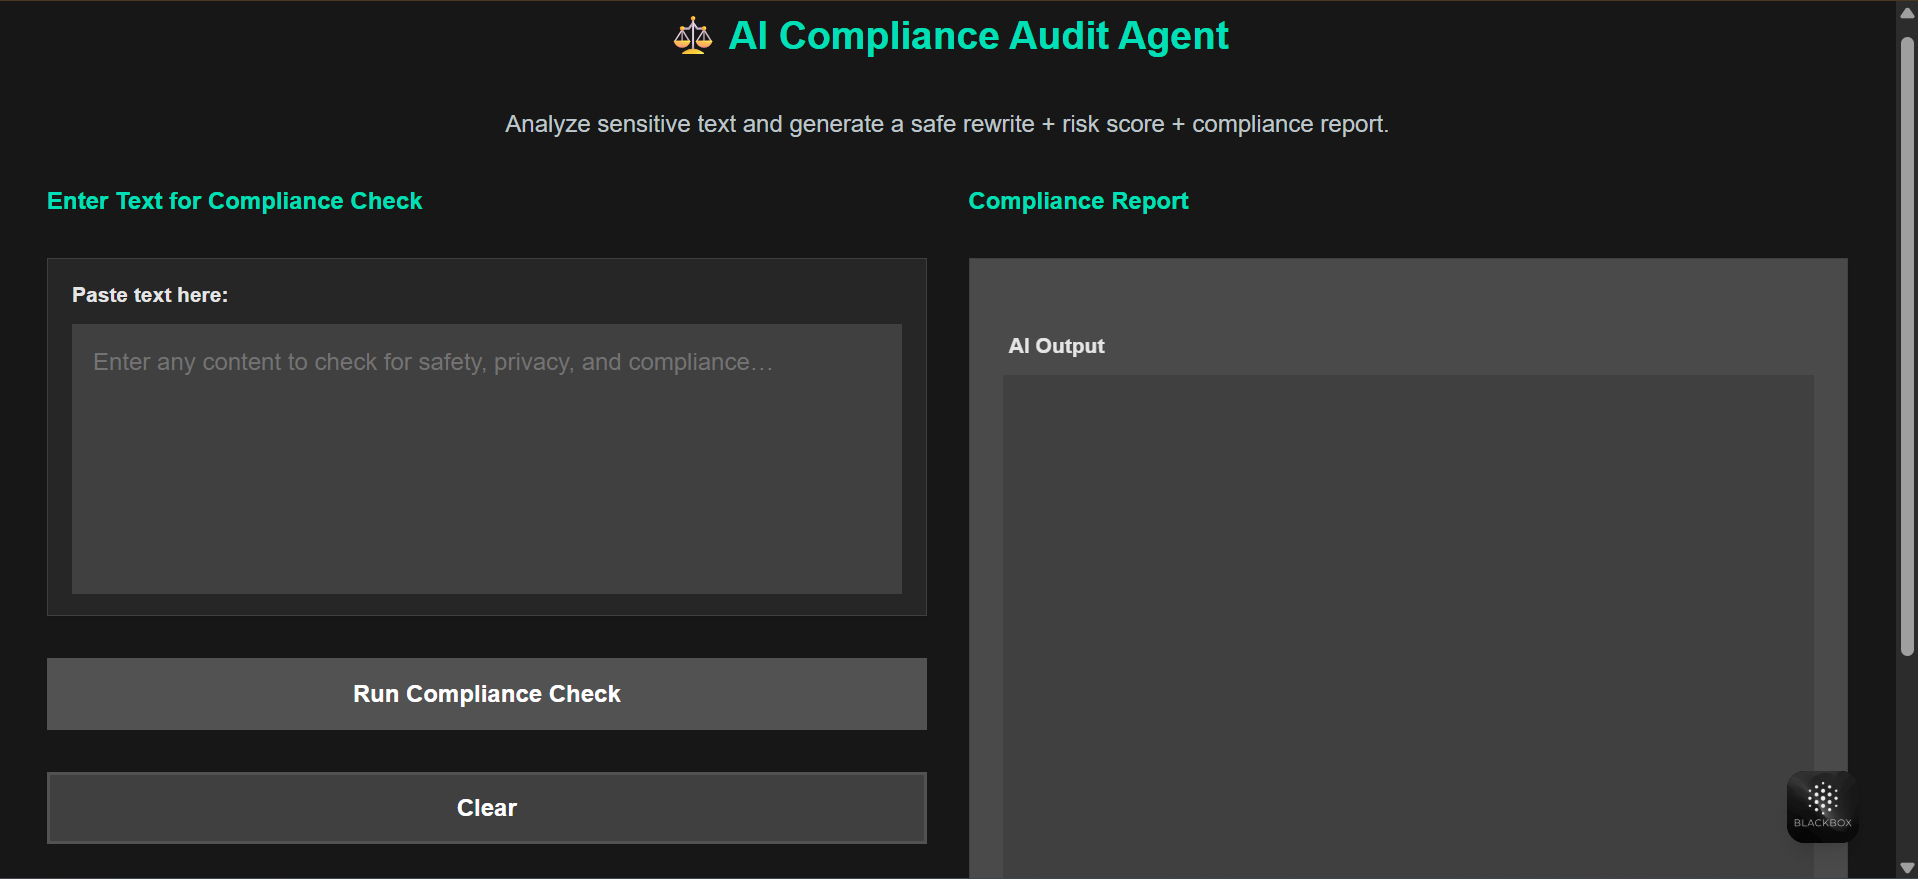](http://)

**Live Agent Link**

**https://84446470e28e727c89.gradio.live/**

**Features Implemented**

Text violation detection

Risk scoring with interpretation

Safe rewritten content

Compliance recommendations

Full structured audit report

Sleek Gradio dashboard

Real-time inference using Cohere

Modular LLM agent design

**Future Improvements**

These extensions can make the agent even more powerful:

PDF & DOCX compliance checking

Batch document uploader

Email or API-based audit automation

Enterprise dashboard with logs

Multi-agent chain for deeper analysis

Redaction (automatic blurring of sensitive text)

Database to store review history

Adding Gemini / OpenAI multi-model support

In [ ]:
!pip install cohere gradio

In [ ]:
import os, json, textwrap
import cohere

# Make sure you set your API key earlier in the notebook as:
# COHERE_API_KEY = "your_key_here"
# If not, set it here (temporary for testing)
COHERE_API_KEY = "e8dIHHSzbaCOnY2VyDxLQBdQMuYkElzXw1ACptO0"  
# initialize cohhere client (will raise clear error if key missing)
co = cohere.Client(COHERE_API_KEY)


In [ ]:
# --- Rule checker ---
def rule_checker(text: str):
    rules = {
        "private data": ["password", "address", "phone number", "private", "secret", "ssn", "social security"],
        "toxicity": ["hate", "stupid", "idiot", "kill", "harm"],
        "bias": ["race", "gender", "religion"],
        "unapproved content": ["confidential", "classified", "not approved", "not approved by"]
    }
    violations = []
    txt = text.lower()
    for rule, keywords in rules.items():
        for k in keywords:
            if k in txt:
                violations.append(rule)
                break
    return list(dict.fromkeys(violations))  # unique order-preserving



In [ ]:
# --- Risk scoring ---
def risk_score(violations):
    if not violations:
        return 5
    base = 20 * len(violations)
    return min(base, 95)

In [ ]:
# --- Correct Cohere Chat wrapper: use 'message' arg (string) ---
def ai_brain(prompt: str, model="command-r-plus-08-2024", temperature=0.4, max_tokens=300):
    """
    Uses Cohere Chat API via co.chat(..., message=prompt).
    Returns the assistant reply text (string).
    """
    # Defensive check
    if not COHERE_API_KEY or COHERE_API_KEY.strip() == "":
        raise ValueError("COHERE_API_KEY is missing. Set COHERE_API_KEY in a previous cell.")
    # Call Cohere correctly with 'message' parameter
    resp = co.chat(
        model=model,
        message=prompt,
        temperature=temperature,
        max_tokens=max_tokens
    )
    # resp.text contains the assistant output for this client wrapper
    # Convert to string and return
    return resp.text if hasattr(resp, "text") else str(resp)

In [ ]:
# --- Main compliance agent ---
def compliance_agent(user_text: str):
    violations = rule_checker(user_text)
    risk = risk_score(violations)

    # Build a clear prompt for the model to produce structured output
    prompt = textwrap.dedent(f"""
    You are a compliance and safety assistant. Analyze the following text and produce a JSON object with keys:
      - short_risk_summary (one sentence)
      - suggestions (a list of up to 6 bullet suggestions to make the text safe)
      - safe_rewrite (a rewritten safe version of the text)

    Input text:
    \"\"\"{user_text}\"\"\"

    Violations detected: {violations}
    Estimated risk score: {risk}/100

    Return ONLY valid JSON.
    """)

    # Call the model
    try:
        model_reply = ai_brain(prompt, model="command-r-plus-08-2024", temperature=0.3, max_tokens=400)
    except Exception as e:
        return {"error": f"Cohere API call failed: {e}", "rule_check": violations, "risk_score": risk}

    # Try parse JSON, but be forgiving if model returns extra text
    # Find first '{' and last '}' and parse substring
    try:
        start = model_reply.find("{")
        end = model_reply.rfind("}") + 1
        if start != -1 and end != -1 and end > start:
            json_text = model_reply[start:end]
            parsed = json.loads(json_text)
        else:
            # fallback: return raw text inside ai_review field
            parsed = {
                "short_risk_summary": "Could not parse structured JSON from model.",
                "suggestions": [],
                "safe_rewrite": model_reply
                }
    except Exception as e:
        parsed = {
            "short_risk_summary": "Parsing failed: " + str(e),
            "suggestions": [],
            "safe_rewrite": model_reply
        }

    return {
        "rule_check": violations if violations else "✔ No violations found",
        "risk_score": risk,
        "ai_review": parsed
    }

In [ ]:
def convert_to_human_readable(result_json):
    ai_review = result_json.get('ai_review', {})
    safe_rewrite = ai_review.get('safe_rewrite', 'N/A')
    short_risk_summary = ai_review.get('short_risk_summary', 'N/A')
    suggestions = ai_review.get('suggestions', [])
    risk_score = result_json.get('risk_score', 0)
    rule_check = result_json.get('rule_check', [])

    # Build the text parts safely
    issues_text = "\n".join([f"- {r}" for r in rule_check]) if rule_check else "No violations detected."
    suggestions_text = "\n".join([f"{i+1}. {s}" for i, s in enumerate(suggestions)]) if suggestions else "No suggestions available."
    risk_level = "Low risk" if risk_score <= 20 else "Medium risk" if risk_score <= 60 else "High risk"

    readable = (
        "==============================\n"
        "📘 AI COMPLIANCE REPORT\n"
        "==============================\n\n"
        "🔍 **Detected Issues:**\n"
        f"{issues_text}\n\n"
        f"⚠️ **Risk Score:** {risk_score} / 100\n"
        f"{risk_level}\n\n"
        "📝 **Summary of Risk:**\n"
        f"{short_risk_summary}\n\n"
        "🛡️ **Safe Rewrite (Corrected Version):**\n"
        f"{safe_rewrite}\n\n"
        "💡 **Recommended Improvements:**\n"
        f"{suggestions_text}\n\n"
        "=============================="
    )

    return readable


In [ ]:
def generate_report(user_text: str):
    """
    Runs the full compliance pipeline:
    1. Detect violations
    2. Generate structured JSON
    3. Convert JSON → human-readable formatted report
    """
    try:
        result = compliance_agent(user_text)   # Structured JSON output
        final_report = convert_to_human_readable(result)
        return final_report
    except Exception as e:
        return f"❌ An error occurred while generating the report:\n{str(e)}"


In [ ]:
import gradio as gr
from datetime import datetime

# ---------------------------
# 1. Generate Human Report
# ---------------------------
def generate_report(user_text):
    if not user_text.strip():
        return "❌ Please enter some text."

    raw = compliance_agent(user_text)          # Your agent
    readable = convert_to_human_readable(raw)  # Human readable output
    return readable


# ---------------------------
# 2. Custom UI CSS
# ---------------------------
css = """
body {background: #0e0f11;}
.gradio-container {font-family: 'Poppins', sans-serif;}

.report-box {
    background: rgba(255, 255, 255, 0.05);
    padding: 22px;
    border-radius: 15px;
    backdrop-filter: blur(10px);
    border: 1px solid rgba(255,255,255,0.15);
    color: #e9e9e9;
    white-space: pre-wrap;
    font-size: 15px;
    line-height: 1.6;
}

#input_area textarea {
    height: 180px !important;
    font-size: 16px;
}

.loading-spin {
    font-size: 18px;
    color: #00e0b8;
    animation: pulse 0.8s infinite alternate;
}

@keyframes pulse {
    from { opacity: 0.3; }
    to { opacity: 1; }
}
"""


# ---------------------------
# 3. Gradio UI
# ---------------------------
with gr.Blocks(css=css, theme=gr.themes.Monochrome(), title="AI Compliance Agent") as demo:

    gr.Markdown("""
        <h1 style="text-align:center; color:#00e0b8;">⚖️ AI Compliance Audit Agent</h1>
        <p style="text-align:center; font-size:16px; color:#bfc6ca;">
            Analyze sensitive text and generate a safe rewrite + risk score + compliance report.
        </p>
    """)

    with gr.Row():

        # ---------------- LEFT SIDE ----------------
        with gr.Column(scale=1):
            gr.Markdown("<h3 style='color:#00e0b8;'>Enter Text for Compliance Check</h3>")

            input_text = gr.Textbox(
                label="Paste text here:",
                placeholder="Enter any content to check for safety, privacy, and compliance…",
                lines=8,
                elem_id="input_area"
            )

            generate_btn = gr.Button("Run Compliance Check", variant="primary")
            clear_btn = gr.Button("Clear")

            loading = gr.Markdown("", elem_classes="loading-spin")


        # ---------------- RIGHT SIDE ----------------
        with gr.Column(scale=1):
            gr.Markdown("<h3 style='color:#00e0b8;'>Compliance Report</h3>")

            output_box = gr.Textbox(
                label="AI Output",
                lines=20,
                interactive=False,
                elem_classes="report-box"
            )


    # ---------------------------
    # 4. Processing function
    # ---------------------------
    def run_and_return(text):
        loading.value = "Processing..."
        report = generate_report(text)
        loading.value = ""
        return report


    generate_btn.click(
        fn=run_and_return,
        inputs=input_text,
        outputs=output_box
    )

    clear_btn.click(lambda: ("", ""), None, [input_text, output_box])


demo.launch()


Conclusion

This project demonstrates a real-world, scalable, enterprise-grade AI agent for text safety auditing. By automating compliance workflows, it showcases: ✔ Agent reasoning ✔ Real-world value ✔ Clean engineering ✔ Effective UI/UX ✔ Multi-module design